In [ ]:
pip install tslearn

     |████████████████████████████████| 798kB 6.5MB/s 


In [ ]:
pip install termcolor

In [ ]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from termcolor import colored

/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7TGUZoLnt5F5aKJNq96tBoW3DaQX04NW2oO_T_-j05VET8L2fAolk
Mounted at /content/drive


In [ ]:
DATA_PATH  ='/content/drive/MyDrive/Series'

class Data:

  num_rows=6
  num_cols=4
  standardization=0
  normalisaion=1
  
  def __init__(self, data_path=DATA_PATH):
    self.series, self.names = self.load(data_path)
    self.longest_serie_index = -1

  def load(self, data_path):

    series = []
    names = []

    for filename in os.listdir(data_path):
      if filename.endswith('csv'):
        df = pd.read_csv('%s/%s' % (DATA_PATH,filename), usecols=['date','value'], parse_dates=True, index_col='date')
        series.append(df)
        names.append(filename)

    return series, names

  def process(self):

    # find longest serie index 
    self.find_longest_serie_index()

    # find longest serie
    longest_serie = self.series[self.longest_serie_index]

    # reindex series
    self.reindex_shorter_serie(longest_serie)

    # remove missing values
    self.impute_time_series()

    # normaliser les series
    normalized_data = self.normalize_serie()

    return normalized_data

  def normalize_serie(self, opt=0):

    series = self.series.copy()
    scaler = None 

    if opt == Data.standardization:
      scaler = StandardScaler()
    else:
      scaler = MinMaxScaler()

    for i in range(len(series)):
      series[i] = scaler.fit_transform(series[i])
      series[i] = series[i].reshape(len(series[i]))

    return np.array(series)


  def find_longest_serie_index(self):

    longest_serie_len = 0
    longest_serie_index = 0
  
    for i, serie in enumerate(self.series):
      if len(serie) > longest_serie_len:
        longest_serie_len = len(serie)
        longest_serie_index = i

    self.longest_serie_index = longest_serie_index

  def reindex_shorter_serie(self, longest_serie):

 
    for i in range(len(self.series)):
      if len(self.series[i]) < len(longest_serie):
        self.series[i] = self.series[i].reindex(longest_serie.index)

  def impute_time_series(self):
    for i in range(len(self.series)):
      if self.series[i].isnull().sum().sum() > 0:
        self.series[i].interpolate(limit_direction="both",inplace=True)

  def plot_series(self, num_rows=num_rows, num_cols=num_cols, colormap='tab20'):

    print(num_rows, num_cols)
    fig, axs = plt.subplots(num_rows,num_cols,figsize=(25,25))
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]

    for num_row in range(num_rows):
      for num_col in range(num_cols):
        if num_row*num_cols + num_col < len(self.series):
          axs[num_row, num_col].plot(self.series[num_row*num_cols + num_col],color=colors[num_row*num_cols + num_col])
          axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))

    plt.show()

  def analyse_series(self, color='red'):
    for i, serie in enumerate(self.series):
      if len(serie) < len(self.series[self.longest_serie_index]) or True :
        print(colored('numero de la serie: %d, date de debut: %s, date de fin: %s, nombre echantillons: %d' %(i,serie.index[0], serie.index[len(serie)-1],len(serie)), color))



In [ ]:
import math
                                                                               
class Kmeans():

  def __init__(self, data, n_clusters, metric):
    self.n_clusters = n_clusters
    self.metric = metric
    self.data = data

  def classify(self):
    self.km = TimeSeriesKMeans(n_clusters=self.n_clusters, metric=self.metric)
    self.labels = self.km.fit_predict(self.data)

  def get_cluster_map(self):
    return self.labels

  def cluster_cardinality(self):
    cluster_card = {'Cluster %d'%(num_cluster +1) : len(self.labels[self.labels == num_cluster])  for num_cluster in range(self.n_clusters)}
    return cluster_card

  def plot_cluster_distribution(self, colormap='rainbow'):

    cluster_card = [len(self.labels[self.labels == num_cluster])  for num_cluster in range(self.n_clusters)]
    cluster_names = ['Cluster %d'%(num_cluster + 1) for num_cluster in range(self.n_clusters)]

    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0,1,self.n_clusters)]

    plt.figure(figsize=(15,5))
    plt.bar(cluster_names, cluster_card,color=colors)
    xlocs =  [i for i in range(self.n_clusters)]
    for i, v in enumerate(cluster_card):
      plt.text(xlocs[i] - 0.25, v + 0.05, str(v), horizontalalignment="center")
    plt.show()

  def plot_kmeans_clusters_shape(self, n_cols=3):
    
    n_rows = int(self.n_clusters / n_cols) if self.n_clusters % n_cols == 0 else int(math.ceil(self.n_clusters / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,15))

    for num_cluster in range(self.n_clusters):
      for serie_index in range(len(self.data)):
        if self.labels[serie_index] == num_cluster:
          axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(self.data[serie_index], c="gray", alpha=0.2)

      axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(self.km.cluster_centers_[num_cluster].ravel(), "r-")
      axs[int(num_cluster / n_cols), num_cluster % n_cols].set_title('Cluster %d'%(num_cluster + 1))
  

In [ ]:
# load data
data = Data()

6 4


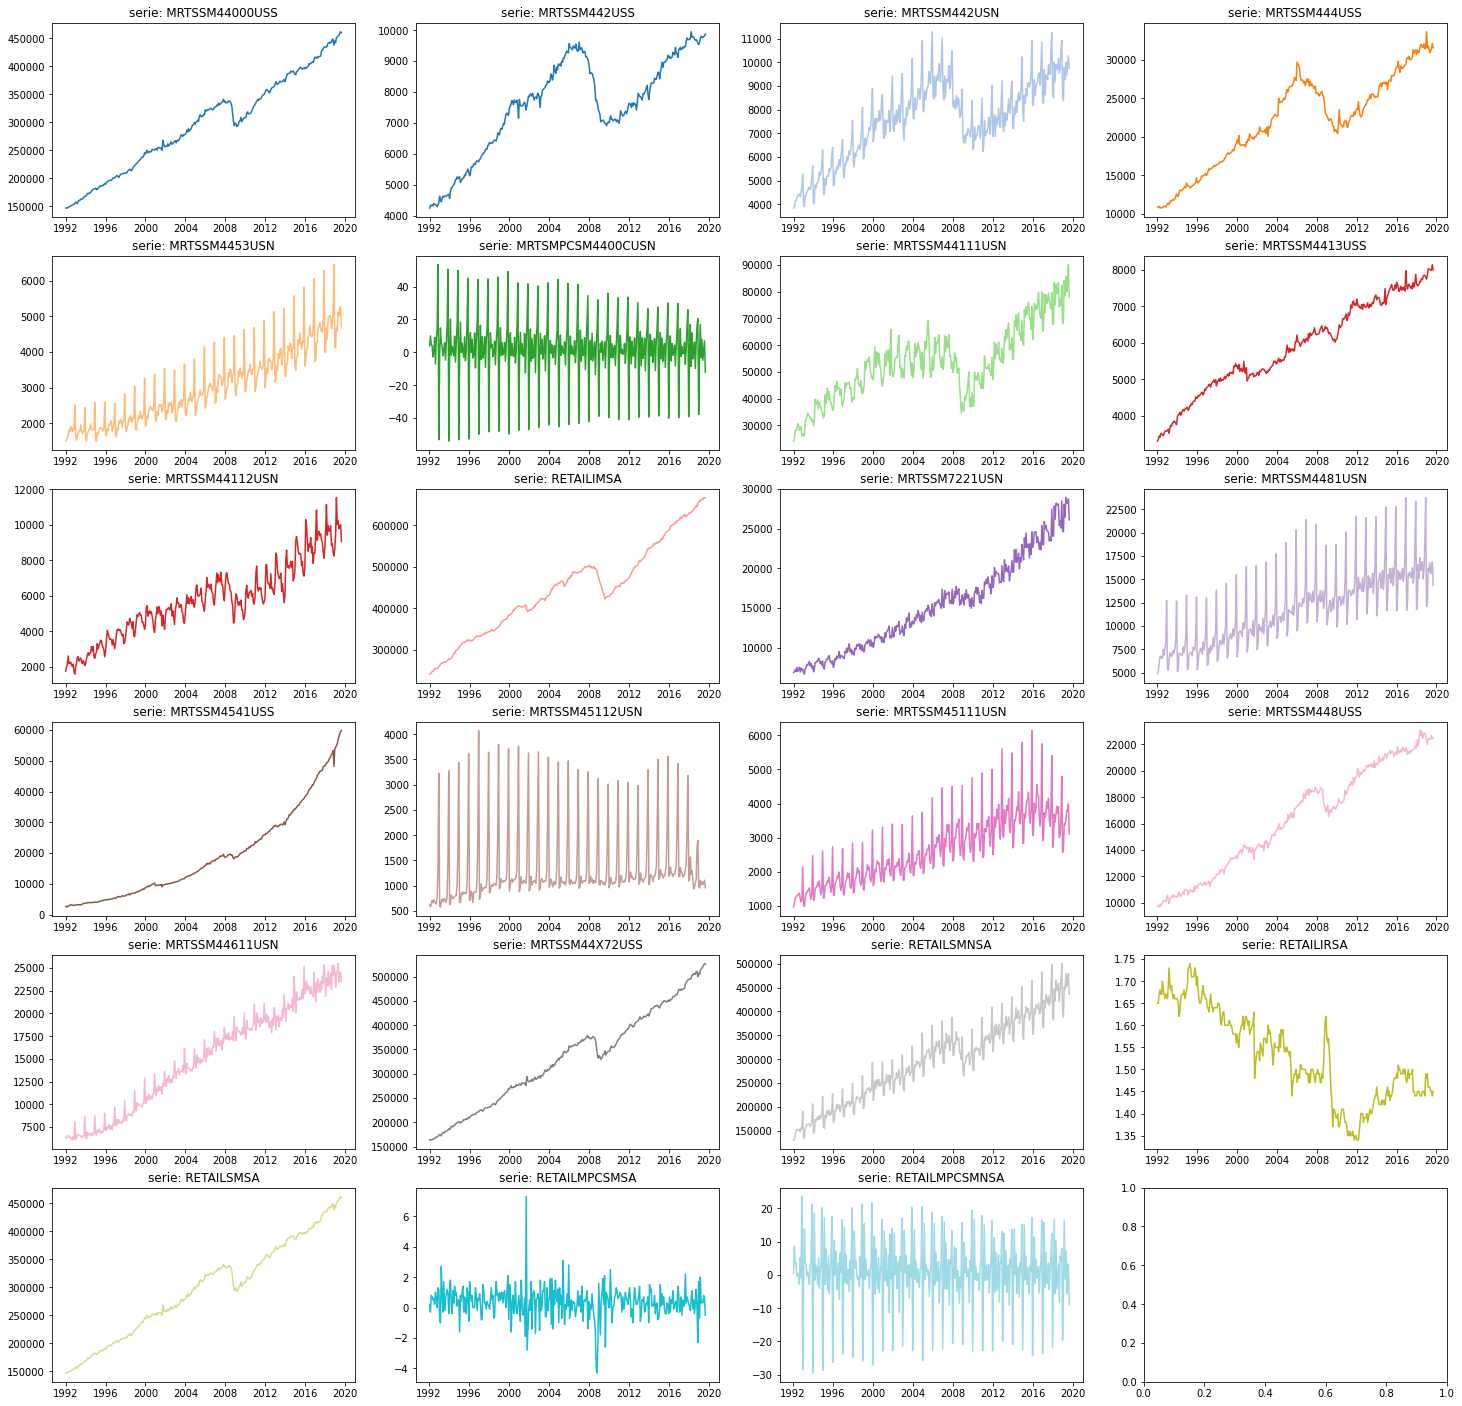

In [ ]:
# visualize data
data.plot_series()

In [ ]:
# cluster times series with kmeans
kmeans = Kmeans(data.process(), 5, 'dtw')
kmeans.classify()

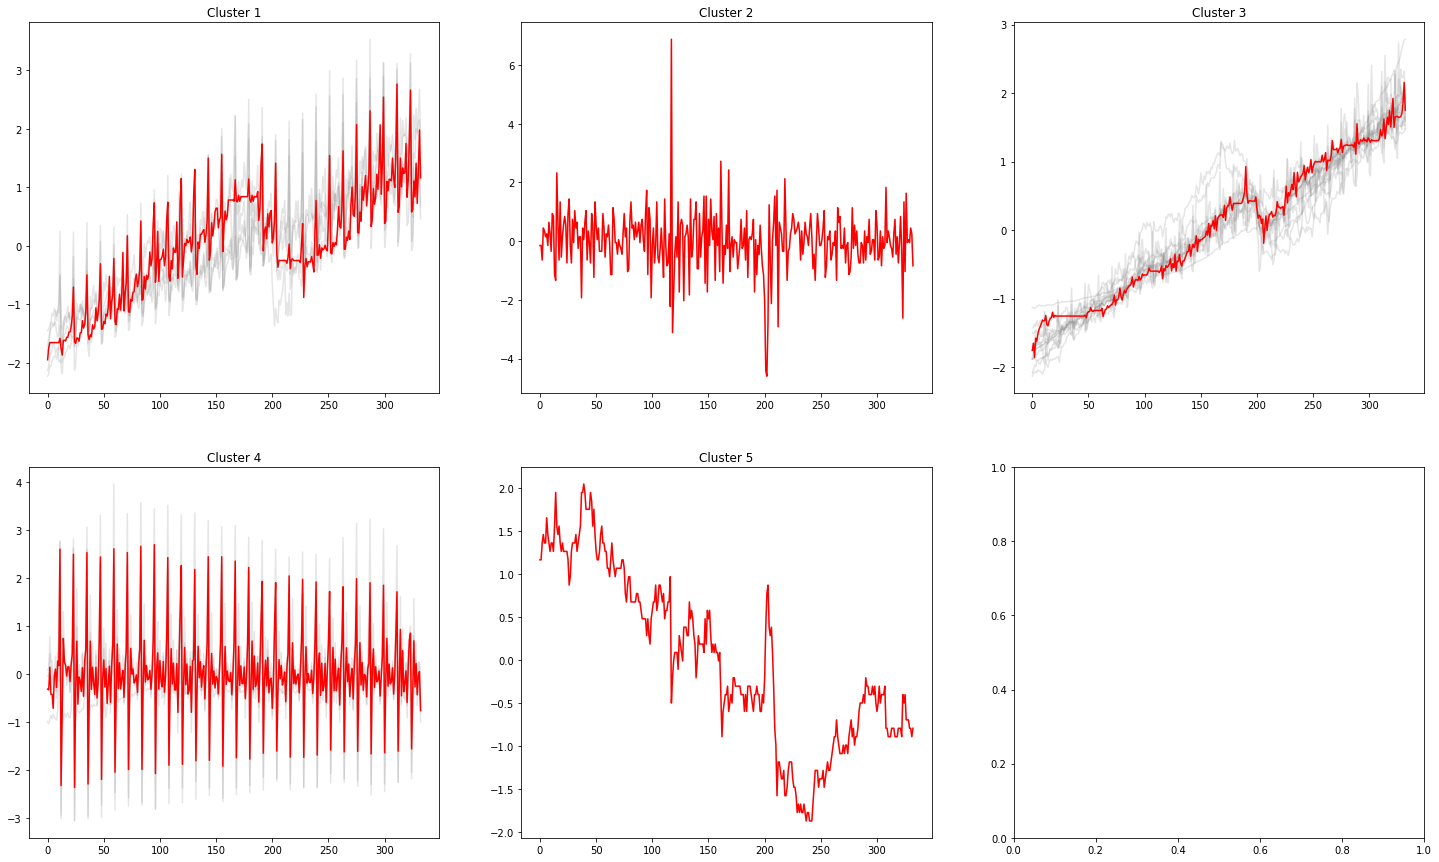

In [ ]:
# visualize cluster's shape
kmeans.plot_kmeans_clusters_shape()

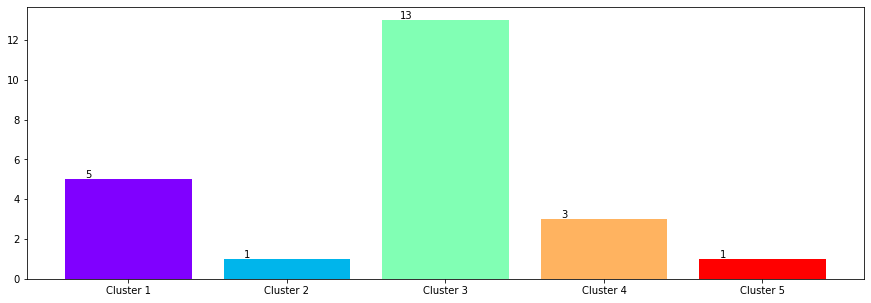

In [ ]:
# visualize cluster's cardinality 
kmeans.plot_cluster_distribution()

In [ ]:
from sklearn.metrics import adjusted_rand_score

def find_optimal_n_clusters(n_tours):
  # each kmeans must have different seed
  seeds = [i for i in range(1000, 1000 + 2*n_tours)]  
w  results = []
  data = Data().process()
  min_n_cluster = 2
  max_n_cluster = 10
  for n_cluster in range(min_n_cluster, max_n_cluster + 1):
    tmp_results = []
    for n_tour in range(n_tours):
      km1 = Kmeans(data, n_cluster, 'dtw', seed=seeds[2*n_tour])
      km2 = Kmeans(data, n_cluster, 'dtw',seed=seeds[2*n_tour + 1])
      km1.classify()
      km2.classify()
      labels1 = km1.labels
      labels2 = km2.labels
      rs = adjusted_rand_score(labels1, labels2)
      tmp_results.append(rs)
    results.append(np.mean(np.array(rs)))
  return results
